## In this section, we built a predictive model to forecast the Sales Amount. 
## We will use a subset of features and build a regression model. 
## Here, a simple Linear Regression model will be applied. 
## For improved performance and to handle non-linearity, more sophisticated models such as RandomForest may be explored in the next section. 
## We will evaluate the model using the R² score.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
datafile_name= "../Data/Data/cleaned_data2_csv.csv"
abt = pd.read_csv(datafile_name, index_col=0)

In [13]:
#selecting numeric features that likely affect Sales
features = ['Quantity', 'Profit Ratio', 'Profit', 'Discount']
target = 'Sales'

In [15]:
# Ensuring the selected features exist in the dataframe
print('Features used for prediction:', features)

X = abt[features]
y = abt[target]

Features used for prediction: ['Quantity', 'Profit Ratio', 'Profit', 'Discount']


In [17]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Initializing and fitting the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
# Predicting on the test set and calculating the R² score
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print(f'R² score of the model: {score:.4f}')

R² score of the model: 0.5867


R² score of the model: 0.5867
The score range: 0 < R² < 1: This explains some but not all of the variance in the target variable. 
A higher R² value indicates a better fit.

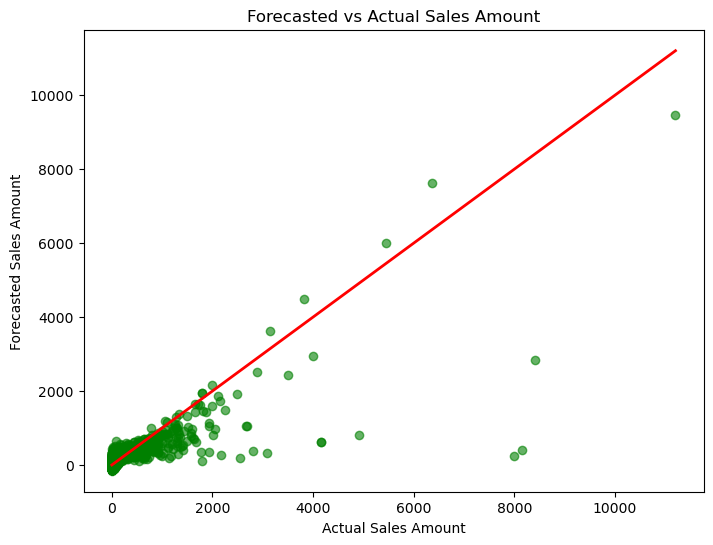

In [25]:
#displaying a plot of Forecasted vs Actual Sales Amount
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.xlabel('Actual Sales Amount')
plt.ylabel('Forecasted Sales Amount')
plt.title('Forecasted vs Actual Sales Amount')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.show()

# Using Linear Regression to predict 'Monthly Sales' based on historical sales data.

In [36]:
# Load the dataset
abt = pd.read_csv(datafile_name, parse_dates=['Order Date'])
abt.set_index('Order Date', inplace=True)

In [38]:
#Creating a supervised learning problem
abt['sales_diff'] = abt['Quantity'].diff()
abt.dropna(inplace=True)

def create_supervised(abt, lag=1):
    abt = pd.DataFrame(abt)
    columns = [abt.shift(i) for i in range(1, lag+1)]
    columns.append(abt)
    abt = pd.concat(columns, axis=1)
    abt.fillna(0, inplace=True)
    return abt

In [40]:
# Creating supervised data for the last 24 months
supervised_data = create_supervised(abt['sales_diff'], 12)

In [42]:
# Splitting data into train and test sets
train_data = supervised_data[:-2000]
test_data = supervised_data[-2000:]

print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (7993, 13)
Test data shape:  (2000, 13)


In [44]:
# Scaling features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [46]:
# Splitting data into input and output
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (7993, 12)
y_train shape:  (7993, 1)
x_test shape:  (2000, 12)
y_test shape:  (2000, 1)


In [48]:
# Creating a DataFrame to store predictions
sales_dates = abt.index[-13:].to_series().reset_index(drop=True)
predict_abt = pd.DataFrame(sales_dates, columns=['Order Date'])

In [50]:
# Actual sales for the last 13 months
actual_sales = abt['Sales'].values[-13:]

In [56]:
# Train the Linear Regression model
import numpy as np
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_predict = lr_model.predict(x_test)

# Inverse transform to original scale
lr_predict = scaler.inverse_transform(np.concatenate((lr_predict, x_test), axis=1))[:, 0]

In [58]:
print(len(lr_predict))
print(len(actual_sales))

2000
13


In [62]:
result_list = []
for index in range(min(len(lr_predict), len(actual_sales))):  # use the smallest length
    result_list.append(lr_predict[index] + actual_sales[index])

lr_predict_series = pd.Series(result_list, name='linear_prediction')

# Calculating forecasted sales
result_list = []
for index in range(len(lr_predict)):
    result_list.append(lr_predict[index] + actual_sales[index])

lr_predict_series = pd.Series(result_list, name='linear_prediction')

In [66]:
# Merging with prediction DataFrame
predict_abt = predict_abt.join(lr_predict_series)

## Evaluating a linear regression model by calculating the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R² score.

In [71]:
#Ensure they are the same length
if len(actual_sales) == len(lr_predict):
    lr_mse = np.sqrt(mean_squared_error(actual_sales, lr_predict))
    lr_mae = mean_absolute_error(actual_sales, lr_predict)
    lr_r2 = r2_score(actual_sales, lr_predict)

    print(f"Linear Regression MSE: {lr_mse}")
    print(f"Linear Regression MAE: {lr_mae}")
    print(f"Linear Regression R2 Score: {lr_r2}")
else:
    print("Error: The lengths of 'actual_sales' and 'lr_predict' do not match.")

Error: The lengths of 'actual_sales' and 'lr_predict' do not match.


In [ ]:
# Model Evaluation
lr_mse = np.sqrt(mean_squared_error(actual_sales[1:], lr_predict[:-1]))
lr_mae = mean_absolute_error(actual_sales[1:], lr_predict[:-1])
lr_r2 = r2_score(actual_sales[1:], lr_predict[:-1])

print(f"Linear Regression MSE: {lr_mse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R2 Score: {lr_r2}")

In [ ]:
# Plotting actual sales vs predicted sales
plt.figure(figsize=(15, 5))
plt.plot(abt.index[-13:], actual_sales, label='Actual Sales')
plt.plot(predict_abt['Order Date'], predict_abt['linear_prediction'], label='Predicted Sales', linestyle='--')
plt.title('Actual Sales vs Predicted Sales')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()
plt.show()